In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix,classification_report

In [2]:
train_df = pd.read_csv("train_data.csv")
train_df.shape

(1799805, 6)

In [3]:
train_df.head()

,date_hour,area_name,date_accident,hour_time,no_of_accidents,is_accident
0,2010-01-01 00:00:00,Olympic,2010-01-01 00:00:00,0,0.0,0
1,2010-01-01 01:00:00,Olympic,2010-01-01 00:00:00,100,1.0,1
2,2010-01-01 02:00:00,Olympic,2010-01-01 00:00:00,200,0.0,0
3,2010-01-01 03:00:00,Olympic,2010-01-01 00:00:00,300,1.0,1
4,2010-01-01 04:00:00,Olympic,2010-01-01 00:00:00,400,0.0,0


In [4]:
#Baseline Prediction for majority classsifer
train_df['is_accident'].value_counts(normalize=True)

0    0.771062
1    0.228938
Name: is_accident, dtype: float64

# Will an accident happen in a area of Los Angeles in the next one hour


### Base Line Accuracy

##### With 77% accuracy we can predict that an accident will not happen in a area within the next one hour

##### As baseline accuracy is high, we will be using AUC ROC metric for Model performance of this classification problem

In [5]:
#Converting columns to datetime
train_df['date_hour']=pd.to_datetime(train_df['date_hour'])

In [6]:
area_names = train_df.area_name.unique()

In [7]:
area_names

array(['Olympic', 'Southeast', 'Foothill', 'Hollywood', 'Mission',
       'Northeast', 'Newton', 'Central', 'N Hollywood', 'Southwest',
       'Harbor', 'Devonshire', 'Pacific', 'Rampart', 'Wilshire',
       '77th Street', 'West LA', 'Topanga', 'Van Nuys', 'West Valley',
       'Hollenbeck'], dtype=object)

In [8]:
#Frequency of accidents in Los Angeles in any given hour
train_df['no_of_accidents'].value_counts(normalize=True)

0.0     7.710619e-01
1.0     1.896428e-01
2.0     3.343084e-02
3.0     5.037212e-03
4.0     7.050764e-04
5.0     9.667714e-05
6.0     1.777970e-05
7.0     4.444926e-06
8.0     1.666847e-06
14.0    5.556157e-07
12.0    5.556157e-07
11.0    5.556157e-07
Name: no_of_accidents, dtype: float64

In [9]:
#Creating features based on no of accidents happened in the past hours in that area
empty_df = []
laghours = [4,12,24,168,720,2880,8760]
for area in area_names:
    train_area = train_df[train_df.area_name==area].copy()
    train_area['no_past1hour']=train_df['no_of_accidents'].shift(1)
    for lhour in laghours:
        name_sum = 'past_'+str(lhour)+'hours_sum'
        name_mean = 'past_'+str(lhour)+'hours_mean'
        name_max = 'past_'+str(lhour)+'hours_max'
        train_area[name_sum]=train_area['no_past1hour'].rolling(lhour).sum()
        train_area[name_mean]=train_area['no_past1hour'].rolling(lhour).mean()
        train_area[name_max]=train_area['no_past1hour'].rolling(lhour).max()
    empty_df.append(train_area)

In [10]:
#Final data after creating features
train = pd.concat(empty_df)
train.shape

(1799805, 28)

In [11]:
#Filling all Nan values with -1
train = train.fillna(-1)

In [12]:
#Adding more features to the data
train['day']=train['date_hour'].dt.day
train['month']=train['date_hour'].dt.month
train['dayofweek']=train['date_hour'].dt.dayofweek
#train['year']=train['date_hour'].dt.year

In [13]:
#Removing No of accidents as that is a leakage feature and date_hour as it is equal to a index
train = train.drop(columns=['no_of_accidents'])
train.shape

(1799805, 30)

In [14]:
train.tail()

,date_hour,area_name,date_accident,hour_time,is_accident,no_past1hour,past_4hours_sum,past_4hours_mean,past_4hours_max,past_12hours_sum,...,past_720hours_max,past_2880hours_sum,past_2880hours_mean,past_2880hours_max,past_8760hours_sum,past_8760hours_mean,past_8760hours_max,day,month,dayofweek
1799800,2019-10-11 20:00:00,Hollenbeck,2019-10-11 00:00:00,2000,0,0.0,0.0,0.0,0.0,0.0,...,4.0,641.0,0.222569,4.0,2020.0,0.230594,4.0,11,10,4
1799801,2019-10-11 21:00:00,Hollenbeck,2019-10-11 00:00:00,2100,0,0.0,0.0,0.0,0.0,0.0,...,4.0,640.0,0.222222,4.0,2020.0,0.230594,4.0,11,10,4
1799802,2019-10-11 22:00:00,Hollenbeck,2019-10-11 00:00:00,2200,0,0.0,0.0,0.0,0.0,0.0,...,4.0,640.0,0.222222,4.0,2020.0,0.230594,4.0,11,10,4
1799803,2019-10-11 23:00:00,Hollenbeck,2019-10-11 00:00:00,2300,0,0.0,0.0,0.0,0.0,0.0,...,4.0,640.0,0.222222,4.0,2020.0,0.230594,4.0,11,10,4
1799804,2019-10-12 00:00:00,Hollenbeck,2019-10-12 00:00:00,0,0,0.0,0.0,0.0,0.0,0.0,...,4.0,640.0,0.222222,4.0,2020.0,0.230594,4.0,12,10,5


In [15]:
#Creating a train,valid and test dataset based on time slicing
#Train set will be data before 2018
#Valid set will be data for year 2018
#Test set will be data for year 2019

In [16]:
target = 'is_accident'

In [17]:
train_set = train[train.date_hour<'2018-01-01']
valid_set = train[(train.date_hour>='2018-01-01')&(train.date_hour<'2019-01-01')]
test_set = train[train.date_hour>='2019-01-01']
print("Train :",train_set.shape[0])
print("Valid :",valid_set.shape[0])
print("Valid :",test_set.shape[0])

Train : 1472688
Valid : 183960
Valid : 143157


In [18]:
#separating target and training data
y_train = train_set[target]
train_set = train_set.drop(columns=target)
y_valid = valid_set[target]
valid_set = valid_set.drop(columns=target)
y_test = test_set[target]
test_set = test_set.drop(columns=target)

In [19]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    #LGBMClassifier(max_depth=8,learning_rate=0.03,n_estimators=1500,min_child_samples=20)
)

In [20]:
features = train_set.columns.drop(['date_hour','date_accident'])

In [21]:
features

Index(['area_name', 'hour_time', 'no_past1hour', 'past_4hours_sum',
       'past_4hours_mean', 'past_4hours_max', 'past_12hours_sum',
       'past_12hours_mean', 'past_12hours_max', 'past_24hours_sum',
       'past_24hours_mean', 'past_24hours_max', 'past_168hours_sum',
       'past_168hours_mean', 'past_168hours_max', 'past_720hours_sum',
       'past_720hours_mean', 'past_720hours_max', 'past_2880hours_sum',
       'past_2880hours_mean', 'past_2880hours_max', 'past_8760hours_sum',
       'past_8760hours_mean', 'past_8760hours_max', 'day', 'month',
       'dayofweek'],
      dtype='object')

In [22]:
 X_train = pipeline.fit_transform(train_set[features])
 X_valid = pipeline.transform(valid_set[features])
 X_test = pipeline.transform(test_set[features])




In [23]:
X_train.head()

,area_name,hour_time,no_past1hour,past_4hours_sum,past_4hours_mean,past_4hours_max,past_12hours_sum,past_12hours_mean,past_12hours_max,past_24hours_sum,...,past_720hours_max,past_2880hours_sum,past_2880hours_mean,past_2880hours_max,past_8760hours_sum,past_8760hours_mean,past_8760hours_max,day,month,dayofweek
0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,1,4
1,1,100,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,1,4
2,1,200,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,1,4
3,1,300,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,1,4
4,1,400,1.0,2.0,0.5,1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,1,4


In [24]:

eval_set = [(X_train,y_train),(X_valid,y_valid)]
model = LGBMClassifier(learning_rate=0.05,subsample= 1.0,
                      n_estimators = 1500,min_child_weight = 3,
                       gamma =  2, colsample_bytree = 0.85, random_state=55)

In [25]:
model.fit(X_train,y_train,eval_set=eval_set,eval_metric='auc',
                      early_stopping_rounds=150)

[1]	training's auc: 0.662019	training's binary_logloss: 0.52908	valid_1's auc: 0.660372	valid_1's binary_logloss: 0.565544
Training until validation scores don't improve for 150 rounds
[2]	training's auc: 0.663107	training's binary_logloss: 0.52661	valid_1's auc: 0.661246	valid_1's binary_logloss: 0.562385
[3]	training's auc: 0.663515	training's binary_logloss: 0.524364	valid_1's auc: 0.661392	valid_1's binary_logloss: 0.559523
[4]	training's auc: 0.663736	training's binary_logloss: 0.522323	valid_1's auc: 0.662016	valid_1's binary_logloss: 0.556937
[5]	training's auc: 0.664507	training's binary_logloss: 0.520444	valid_1's auc: 0.662829	valid_1's binary_logloss: 0.55461
[6]	training's auc: 0.664932	training's binary_logloss: 0.518735	valid_1's auc: 0.663115	valid_1's binary_logloss: 0.552565
[7]	training's auc: 0.665399	training's binary_logloss: 0.517343	valid_1's auc: 0.66363	valid_1's binary_logloss: 0.55085
[8]	training's auc: 0.666038	training's binary_logloss: 0.516913	valid_1's 

[67]	training's auc: 0.67193	training's binary_logloss: 0.498639	valid_1's auc: 0.669306	valid_1's binary_logloss: 0.53167
[68]	training's auc: 0.671991	training's binary_logloss: 0.498595	valid_1's auc: 0.669359	valid_1's binary_logloss: 0.531634
[69]	training's auc: 0.672091	training's binary_logloss: 0.498542	valid_1's auc: 0.669422	valid_1's binary_logloss: 0.531596
[70]	training's auc: 0.672158	training's binary_logloss: 0.498497	valid_1's auc: 0.66947	valid_1's binary_logloss: 0.531562
[71]	training's auc: 0.672216	training's binary_logloss: 0.49845	valid_1's auc: 0.669485	valid_1's binary_logloss: 0.531542
[72]	training's auc: 0.672267	training's binary_logloss: 0.498428	valid_1's auc: 0.66952	valid_1's binary_logloss: 0.531526
[73]	training's auc: 0.672344	training's binary_logloss: 0.498386	valid_1's auc: 0.669595	valid_1's binary_logloss: 0.531487
[74]	training's auc: 0.672376	training's binary_logloss: 0.498351	valid_1's auc: 0.669608	valid_1's binary_logloss: 0.531471
[75]	

[133]	training's auc: 0.674797	training's binary_logloss: 0.49717	valid_1's auc: 0.670775	valid_1's binary_logloss: 0.530838
[134]	training's auc: 0.67482	training's binary_logloss: 0.497162	valid_1's auc: 0.670761	valid_1's binary_logloss: 0.530843
[135]	training's auc: 0.674849	training's binary_logloss: 0.497152	valid_1's auc: 0.670766	valid_1's binary_logloss: 0.53084
[136]	training's auc: 0.674873	training's binary_logloss: 0.497144	valid_1's auc: 0.670767	valid_1's binary_logloss: 0.530841
[137]	training's auc: 0.67489	training's binary_logloss: 0.497136	valid_1's auc: 0.670765	valid_1's binary_logloss: 0.530842
[138]	training's auc: 0.674918	training's binary_logloss: 0.497125	valid_1's auc: 0.670764	valid_1's binary_logloss: 0.530844
[139]	training's auc: 0.674946	training's binary_logloss: 0.497113	valid_1's auc: 0.670784	valid_1's binary_logloss: 0.530835
[140]	training's auc: 0.674965	training's binary_logloss: 0.497106	valid_1's auc: 0.670787	valid_1's binary_logloss: 0.530

[199]	training's auc: 0.676263	training's binary_logloss: 0.496564	valid_1's auc: 0.67097	valid_1's binary_logloss: 0.530741
[200]	training's auc: 0.676294	training's binary_logloss: 0.496551	valid_1's auc: 0.670991	valid_1's binary_logloss: 0.530732
[201]	training's auc: 0.676312	training's binary_logloss: 0.496545	valid_1's auc: 0.670985	valid_1's binary_logloss: 0.530733
[202]	training's auc: 0.676331	training's binary_logloss: 0.496537	valid_1's auc: 0.670987	valid_1's binary_logloss: 0.530732
[203]	training's auc: 0.676351	training's binary_logloss: 0.49653	valid_1's auc: 0.670979	valid_1's binary_logloss: 0.530734
[204]	training's auc: 0.676398	training's binary_logloss: 0.496509	valid_1's auc: 0.671012	valid_1's binary_logloss: 0.530719
[205]	training's auc: 0.676414	training's binary_logloss: 0.496503	valid_1's auc: 0.671011	valid_1's binary_logloss: 0.530719
[206]	training's auc: 0.676436	training's binary_logloss: 0.496489	valid_1's auc: 0.67101	valid_1's binary_logloss: 0.53

[266]	training's auc: 0.677625	training's binary_logloss: 0.496019	valid_1's auc: 0.671092	valid_1's binary_logloss: 0.530674
[267]	training's auc: 0.67764	training's binary_logloss: 0.496013	valid_1's auc: 0.671092	valid_1's binary_logloss: 0.530674
[268]	training's auc: 0.677672	training's binary_logloss: 0.496	valid_1's auc: 0.671112	valid_1's binary_logloss: 0.530665
[269]	training's auc: 0.677681	training's binary_logloss: 0.495995	valid_1's auc: 0.671117	valid_1's binary_logloss: 0.530663
[270]	training's auc: 0.677702	training's binary_logloss: 0.495986	valid_1's auc: 0.671118	valid_1's binary_logloss: 0.530661
[271]	training's auc: 0.677716	training's binary_logloss: 0.49598	valid_1's auc: 0.671113	valid_1's binary_logloss: 0.530664
[272]	training's auc: 0.677739	training's binary_logloss: 0.495972	valid_1's auc: 0.671109	valid_1's binary_logloss: 0.530665
[273]	training's auc: 0.677755	training's binary_logloss: 0.495966	valid_1's auc: 0.671109	valid_1's binary_logloss: 0.5306

[333]	training's auc: 0.678921	training's binary_logloss: 0.495513	valid_1's auc: 0.671107	valid_1's binary_logloss: 0.530665
[334]	training's auc: 0.678937	training's binary_logloss: 0.495507	valid_1's auc: 0.671081	valid_1's binary_logloss: 0.530676
[335]	training's auc: 0.678958	training's binary_logloss: 0.495498	valid_1's auc: 0.671081	valid_1's binary_logloss: 0.530676
[336]	training's auc: 0.678976	training's binary_logloss: 0.495491	valid_1's auc: 0.671081	valid_1's binary_logloss: 0.530676
[337]	training's auc: 0.678999	training's binary_logloss: 0.495483	valid_1's auc: 0.671083	valid_1's binary_logloss: 0.530676
[338]	training's auc: 0.679018	training's binary_logloss: 0.495475	valid_1's auc: 0.671077	valid_1's binary_logloss: 0.530678
[339]	training's auc: 0.679036	training's binary_logloss: 0.495468	valid_1's auc: 0.671034	valid_1's binary_logloss: 0.530692
[340]	training's auc: 0.679049	training's binary_logloss: 0.495464	valid_1's auc: 0.671032	valid_1's binary_logloss: 0

[399]	training's auc: 0.680125	training's binary_logloss: 0.495037	valid_1's auc: 0.670978	valid_1's binary_logloss: 0.530705
[400]	training's auc: 0.680148	training's binary_logloss: 0.49503	valid_1's auc: 0.67096	valid_1's binary_logloss: 0.530712
[401]	training's auc: 0.680165	training's binary_logloss: 0.495023	valid_1's auc: 0.670948	valid_1's binary_logloss: 0.530718
[402]	training's auc: 0.680178	training's binary_logloss: 0.495017	valid_1's auc: 0.670946	valid_1's binary_logloss: 0.530719
[403]	training's auc: 0.680202	training's binary_logloss: 0.495007	valid_1's auc: 0.670957	valid_1's binary_logloss: 0.530714
Early stopping, best iteration is:
[253]	training's auc: 0.677398	training's binary_logloss: 0.496105	valid_1's auc: 0.67114	valid_1's binary_logloss: 0.530656


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.85,
               gamma=2, importance_type='split', learning_rate=0.05,
               max_depth=-1, min_child_samples=20, min_child_weight=3,
               min_split_gain=0.0, n_estimators=1500, n_jobs=-1, num_leaves=31,
               objective=None, random_state=55, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [26]:
#roc auc score for valid set
roc_auc_score(y_valid,model.predict_proba(X_valid)[:,1])

0.6711397890354959

In [27]:
#roc auc score for test set
roc_auc_score(y_test,model.predict_proba(X_test)[:,1])

0.6703697432329496

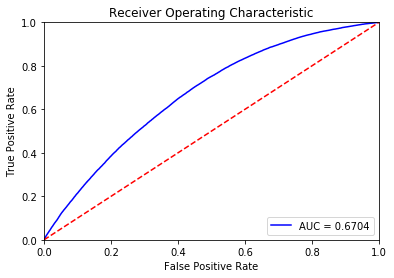

In [36]:
#ROC AUC Curve plotting
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
confusion_matrix(y_test,model.predict(X_test))

array([[107381,    189],
       [ 35396,    191]])

In [30]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86    107570
           1       0.50      0.01      0.01     35587

    accuracy                           0.75    143157
   macro avg       0.63      0.50      0.43    143157
weighted avg       0.69      0.75      0.65    143157



In [31]:
test_set.tail()

,date_hour,area_name,date_accident,hour_time,no_past1hour,past_4hours_sum,past_4hours_mean,past_4hours_max,past_12hours_sum,past_12hours_mean,...,past_720hours_max,past_2880hours_sum,past_2880hours_mean,past_2880hours_max,past_8760hours_sum,past_8760hours_mean,past_8760hours_max,day,month,dayofweek
1799800,2019-10-11 20:00:00,Hollenbeck,2019-10-11 00:00:00,2000,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,641.0,0.222569,4.0,2020.0,0.230594,4.0,11,10,4
1799801,2019-10-11 21:00:00,Hollenbeck,2019-10-11 00:00:00,2100,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,640.0,0.222222,4.0,2020.0,0.230594,4.0,11,10,4
1799802,2019-10-11 22:00:00,Hollenbeck,2019-10-11 00:00:00,2200,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,640.0,0.222222,4.0,2020.0,0.230594,4.0,11,10,4
1799803,2019-10-11 23:00:00,Hollenbeck,2019-10-11 00:00:00,2300,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,640.0,0.222222,4.0,2020.0,0.230594,4.0,11,10,4
1799804,2019-10-12 00:00:00,Hollenbeck,2019-10-12 00:00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,640.0,0.222222,4.0,2020.0,0.230594,4.0,12,10,5


In [32]:
predict_set = test_set[test_set.date_hour=='2019-10-11 23:00:00']

###  Please provide the inputs in the below cell to get the predictions for LA areas

In [33]:
#Add appropriate values to predict the crash probabilities based on the day and time
# predict_set['day']  = #set the value of the day
# predcit_set['month'] = # set the value of the month
# predict_set['dayofweek'] = #set the value of the day of the week

In [34]:
#Creatin a dataframe to predict the crash categories of areas
crash_probability = model.predict_proba(pipeline.transform(predict_set[features]))[:,1]
predict_areas = predict_set['area_name'].values
crash_areas = pd.DataFrame({'area_name':predict_areas,'probability':crash_probability}).sort_values('probability').reset_index(drop=True)
crash_categories = ['low' for i in range(7)]+['medium' for i in range(7)]+ ['high' for i in range(7)]
crash_areas['category']=crash_categories

In [35]:
crash_areas

,area_name,probability,category
0,Hollenbeck,0.213110,low
1,Harbor,0.219186,low
2,Topanga,0.224266,low
3,Central,0.237105,low
4,Rampart,0.238375,low
5,Foothill,0.244473,low
6,West Valley,0.244664,low
7,West LA,0.258473,medium
8,Van Nuys,0.259615,medium
9,Devonshire,0.260154,medium
